In [2]:
import os, sys
os.chdir("../")
path = os.getcwd()
sys.path.insert(0, path)
import GWGen
from GWGen.Utils import *
from GWGen.WFGenerator import *
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal
import superrad


# set initial parameters
M = 1e7
m = 1e1
mu = 1.e-18
e0 = 0.2
p0 = 6#GetInitialP(M,e0)
Phi_phi0 = 0.
Phi_theta0 =0.
Phi_r0 = 0.


a=0.9 #SMBH Spin
Y0=1. #Initial Inclincation
qS=np.pi/4 #Sky Location Polar Angle in solar system barycenter coordinate system
phiS=0. #Sky Location Azimuthal Angle in solar system barycenter coordinate system
qK=1e-6 #Initial BH Spin Polar Angle in solar system barycenter coordinate system
phiK=0. #Initial BH Spin Azimuthal Angle in solar system barycenter coordinate system
dist=1. #Distance to source (Mpc)
mich=False #assume LISA long baseline response approximation

T=4 #LISA data run is 5 years. We set the max time to be longer because the proca cloud extends the inspiral time
dt=15 #time resolution in seconds

alphaval = alphavalue(M,mu)



use_gpu = False

# keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
insp_kwargs = {
    "npoints": 110,  # we want a densely sampled trajectory
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "dense_output":True
}

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

def innerprod4(td,w1,w2):
    wv1fft = sp.fft.fft(w1)
    wv2fft = sp.fft.fft(w2)
    freqs = sp.fft.fftfreq(len(td), d=float(td[1]-td[0]))
    wv1fft = wv1fft[1:]
    wv2fft = wv2fft[1:]
    freqs = freqs[1:]
    lisasens = LisaSensitivity(np.abs(freqs))
    t1 = sp.fft.ifft(wv1fft/lisasens)
    t2 = sp.fft.ifft(np.conjugate(wv2fft))
    conv = sp.signal.convolve(t1,t2,method="fft", mode="full")
    convlen = int(len(conv))+1
    #plt.plot(conv)
    #plt.scatter([convlen/2], [conv[int(convlen/2)]])
    if np.all(w1==w2):
        return 2*np.real(conv[int(convlen/2)])
    return 2*np.real(conv)

WithoutProcaInspiralKwargs = insp_kwargs.copy()
WithoutProcaSumKwargs=sum_kwargs.copy()
withoutprocagen = EMRIWaveform(inspiral_kwargs=WithoutProcaInspiralKwargs, sum_kwargs=WithoutProcaSumKwargs, use_gpu=False)
ulb = superrad.ultralight_boson.UltralightBoson(spin=1,model="relativistic")
withprocagen = EMRIWithProcaWaveform(inspiral_kwargs=insp_kwargs.copy(),sum_kwargs=sum_kwargs.copy())
print(r"alpha = {0}".format(alphaval))
print("initial p = {0}".format(p0))

alpha = 0.07483138061572224
initial p = 6


In [2]:
wv1 = withoutprocagen(M, m, a, p0, e0, Y0, qS, phiS, qK, phiK, dist,Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, mich=mich, dt=dt, T=T)
#wv2 = withoutprocagen(M, m, a, 10, e0, Y0, qS, phiS, qK, phiK, dist,Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, mich=mich, dt=dt, T=T)
wv2 = withprocagen(M,m,mu,a,p0,e0,Y0,T=T,qS=qS,phiS=phiS,qK=qK,phiK=phiK,dist=dist,mich=mich, UltralightBoson=ulb)

if len(wv1)<len(wv2):
    wv1 = np.pad(wv1, (0,len(wv2)-len(wv1)))
elif len(wv2)<len(wv1):
    wv2= np.pad(wv2, (0,len(wv1)-len(wv2)))

minlen = min([len(wv1), len(wv2)])
td = np.arange(minlen)*dt
#wv1 = wv1[:minlen]
#wv3 = wv3[:minlen]

/mnt/Data_Volume/Documents/software/Anaconda/envs/few_env/lib/python3.7/site-packages/few/summation/aakwave.py:228: UserWarning: Inclination trajectory includes values within 1e-6 of the poles. We shift these values automatically away from poles by 1e-6.
  "Inclination trajectory includes values within 1e-6 of the poles. We shift these values automatically away from poles by 1e-6."


In [5]:
alphavalue(M,5e-18)

<Quantity 0.3741569>

In [6]:
Faithfulness(td, wv1, wv2)

[ 7.92188357e-09  1.58437671e-08  2.37656507e-08 ... -2.37656507e-08
 -1.58437671e-08 -7.92188357e-09]
[ 7.92188357e-09  1.58437671e-08  2.37656507e-08 ... -2.37656507e-08
 -1.58437671e-08 -7.92188357e-09]
[ 7.92188357e-09  1.58437671e-08  2.37656507e-08 ... -2.37656507e-08
 -1.58437671e-08 -7.92188357e-09]


0.9999999999539428

In [2]:
fai = []
for i in np.linspace(1.e-18,4.5e-18,10):
    print("wv1")
    wv1 = withoutprocagen(M, m, a, p0, e0, Y0, qS, phiS, qK, phiK, dist,Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, mich=mich, dt=dt, T=T)
    print('wv2')
    wv2 = withprocagen(M,m,i,a,p0,e0,Y0,T=T,qS=qS,phiS=phiS,qK=qK,phiK=phiK,dist=dist,mich=mich, UltralightBoson=ulb)
    
    if len(wv1)<len(wv2):
        wv1 = np.pad(wv1, (0,len(wv2)-len(wv1)))
    elif len(wv2)<len(wv1):
        wv2= np.pad(wv2, (0,len(wv1)-len(wv2)))
    
    minlen = min([len(wv1), len(wv2)])
    td = np.arange(minlen)*dt
    #wv1 = wv1[:minlen]
    #wv2 = wv2[:minlen]
    print("innerproducts")
    res1 = innerprod4(td,wv1,wv2)
    res2 = innerprod4(td,wv1,wv1)
    res3 = innerprod4(td,wv2,wv2)
    fai.append(
        [i,res1,res2,res3]
    )
    print(i)
fai = np.asarray(fai)

wv1


/mnt/Data_Volume/Documents/software/Anaconda/envs/few_env/lib/python3.7/site-packages/few/summation/aakwave.py:228: UserWarning: Inclination trajectory includes values within 1e-6 of the poles. We shift these values automatically away from poles by 1e-6.
  "Inclination trajectory includes values within 1e-6 of the poles. We shift these values automatically away from poles by 1e-6."


wv2
innerproducts
1e-18
wv1
wv2
innerproducts
1.3888888888888889e-18
wv1
wv2
innerproducts
1.7777777777777777e-18
wv1
wv2
innerproducts
2.1666666666666667e-18
wv1
wv2
innerproducts
2.5555555555555553e-18
wv1
wv2
innerproducts
2.9444444444444443e-18
wv1
wv2
innerproducts
3.3333333333333333e-18
wv1
wv2
innerproducts
3.722222222222222e-18
wv1
wv2
innerproducts
4.111111111111111e-18
wv1
wv2


AssertionError: ERROR: requested alpha outside range of available data. Alpha parameters must be in range [0.020, 0.315]

/home/shaunf/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


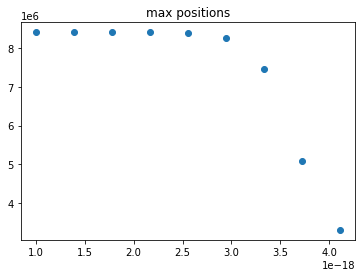

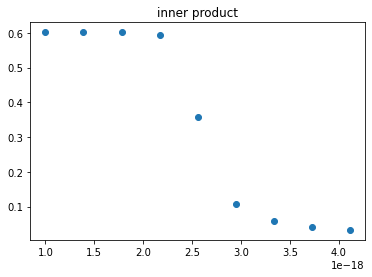

Text(0.5, 1.0, 'faithfulness')

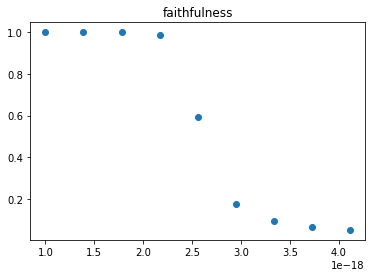

In [3]:
fai = np.asarray(fai)
args = [np.argmax(i) for i in fai[:,1]]
vals = np.array([np.max(i) for i in fai[:,1]])
norms = np.sqrt(np.array(fai[:,3]*fai[:,2],dtype=np.float64))
faiths = vals/norms
plt.scatter(fai[:,0], args)
plt.title("max positions")
plt.show()
plt.scatter(fai[:,0], vals)
plt.title("inner product")
plt.show()
plt.scatter(fai[:,0], faiths)

plt.title("faithfulness")

In [25]:
def innerprod2(td,w1,w2):
    wv1fft = sp.fft.fft(w1)
    wv2fft = sp.fft.fft(w2)
    freqs = sp.fft.fftfreq(len(td), d=float(td[1]-td[0]))
    leng = np.argmax(freqs)
    wv1fft = wv1fft[1:leng]
    wv2fft = wv2fft[1:leng]
    freqs = freqs[1:leng]
    lisasens = LisaSensitivity(freqs)
    integrand = wv1fft * np.conjugate(wv2fft)/lisasens
    res = 4*sp.integrate.simpson(integrand.real,x=freqs)
    return res

def innerprod3(td,w1,w2):
    wv1fft = sp.fft.fft(w1)
    wv2fft = sp.fft.fft(w2)
    freqs = sp.fft.fftfreq(len(td), d=float(td[1]-td[0]))
    wv1fft = wv1fft[1:]
    wv2fft = wv2fft[1:]
    freqs = freqs[1:]
    lisasens = LisaSensitivity(np.abs(freqs))
    integrand = wv1fft * np.conjugate(wv2fft)/lisasens
    res = 4*sp.integrate.simpson(integrand.real,x=freqs)
    return res

def innerprod1(td, w1,w2):
    wv1fft = sp.fft.fft(w1)[1:]
    wv2fft = sp.fft.fft(w2)[1:]
    freqs = sp.fft.fftfreq(len(td), d=float(td[1]-td[0]))
    lisasens = LisaSensitivity(np.abs(freqs[1:]))
    integrand = wv1fft * np.conjugate(wv2fft)/lisasens
    
    res = 2*np.real(np.fft.ifft(integrand))
    return res

In [26]:
t11 = innerprod1(td,wv1,wv2)
t12 = innerprod1(td,wv1,wv1)
t13 = innerprod1(td,wv2,wv2)
t21 = innerprod2(td,wv1,wv2)
t22 = innerprod2(td,wv1,wv1)
t23 = innerprod2(td,wv2,wv2)
t31 = innerprod3(td,wv1,wv2)
t32 = innerprod3(td,wv1,wv1)
t33 = innerprod3(td,wv2,wv2)

In [29]:
print(t21)


10.144870228699


In [207]:
Faithfulness(td,wv1,wv2,maximize=False)

0.0025716253226998084

In [208]:
Faithfulness(td,wv1,wv2,maximize=True)

0.003312713667170766

In [209]:
get_mismatch(wv1,wv2)

0.997968728416214

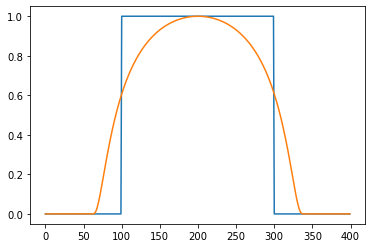

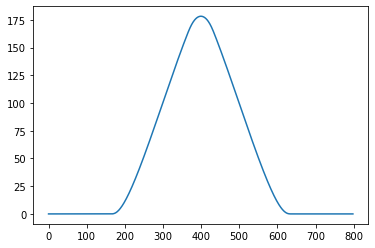

In [54]:
def fun(x):
    sig = 2
    if x**2<sig:
        return np.exp(-1/(sig-x**2))/np.exp(-1/sig)
    else:
        return 0
def fun2(x):
    if np.abs(x)<1:
        return 1
    else:
        return 0
dom = np.arange(-2,2,0.01)
ran = np.array([fun(i) for i in dom])
ran1 = np.array([fun2(i) for i in dom])
conv = sp.signal.convolve(ran,ran1,method="fft")
plt.plot(ran1)
plt.plot(ran)
plt.show()
plt.plot(conv)

In [53]:
len(ran)

400

In [49]:
sp.integrate.simpson(ran*ran1)

178.27950364427485

In [267]:
Norm = "backward"
wv1f = np.fft.fft(wv1, norm=Norm)
wv2f = np.fft.fft(wv2, norm=Norm)
fd = np.fft.fftfreq(len(td),d=float(td[1]-td[0]))
fdlen = int(len(fd)/2)
fd = fd[1:fdlen]
wv1ft = wv1f[1:fdlen]
wv2ft = wv2f[1:fdlen]
wv2fstar = np.conjugate(wv2ft)
wv1fstar = np.conjugate(wv1ft)
psd = LisaSensitivity(fd)
integrand = wv1ft*wv2fstar/psd*tophatran
integrandwv1 = wv1ft*wv1fstar/psd*tophatran
integrandwv2 = wv2ft*wv2fstar/psd*tophatran
tophatran = [tophat(x,0.0001,1) for x in fd]

intfft = 4*np.real(np.fft.ifft(wv1ft/psd*wv2fstar*tophatran, norm=Norm))
intfftwv1 =  4*np.real(np.fft.ifft(wv1ft/psd*wv1fstar*tophatran, norm=Norm))
intfftwv2 =  4*np.real(np.fft.ifft(wv2ft/psd*wv2fstar*tophatran, norm=Norm))
integral = 4*sp.integrate.simpson(integrand.real,x=fd)
integralwv1 = 4*sp.integrate.simpson(integrandwv1.real,x=fd)
integralwv2 = 4*sp.integrate.simpson(integrandwv2.real,x=fd)


print(max(intfft))
print(max(intfft)/(intfftwv1[0]*intfftwv2[0]))
print(integral)
print(integral/(integralwv1*integralwv2))

8.709977542804772
4.95465131459995e-05
0.03304060249210041
0.00016915625178645378


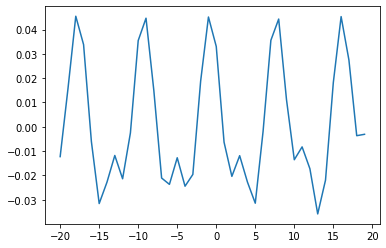

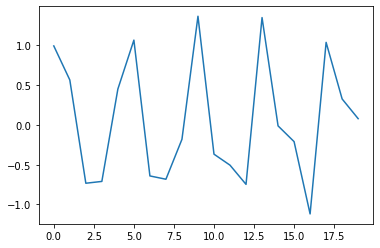

In [256]:
phasearr = lambda n: np.exp(-2*np.pi*1j*n*dt*fd)
dom = np.arange(-20,20)
ran = [4*sp.integrate.simpson((integrand*phasearr(n)).real,x=fd) for n in dom]
plt.plot(dom, ran)
plt.show()
plt.plot(intfft[:20])

In [189]:
freqs=np.fft.fftfreq(len(wv1))
freqs=freqs[:int(len(freqs)/2)]
wv1f = np.fft.fft(wv1)[:int(len(freqs))]
wv2f = np.fft.fft(wv2)[:int(len(freqs))]
lisasen = LisaSensitivity(freqs)

In [190]:
def mollifier(x,f1,f2,n):
    if f1<x<f2:
        return np.exp(-1/(((f2-f1)/2)**n - (x - (f2+f1)/2)**n) + (2/(f2-f1))**n)
    else:
        return 0
def tophat(x,f1,f2):
    if f1<x<f2: return 1
    else: return 0


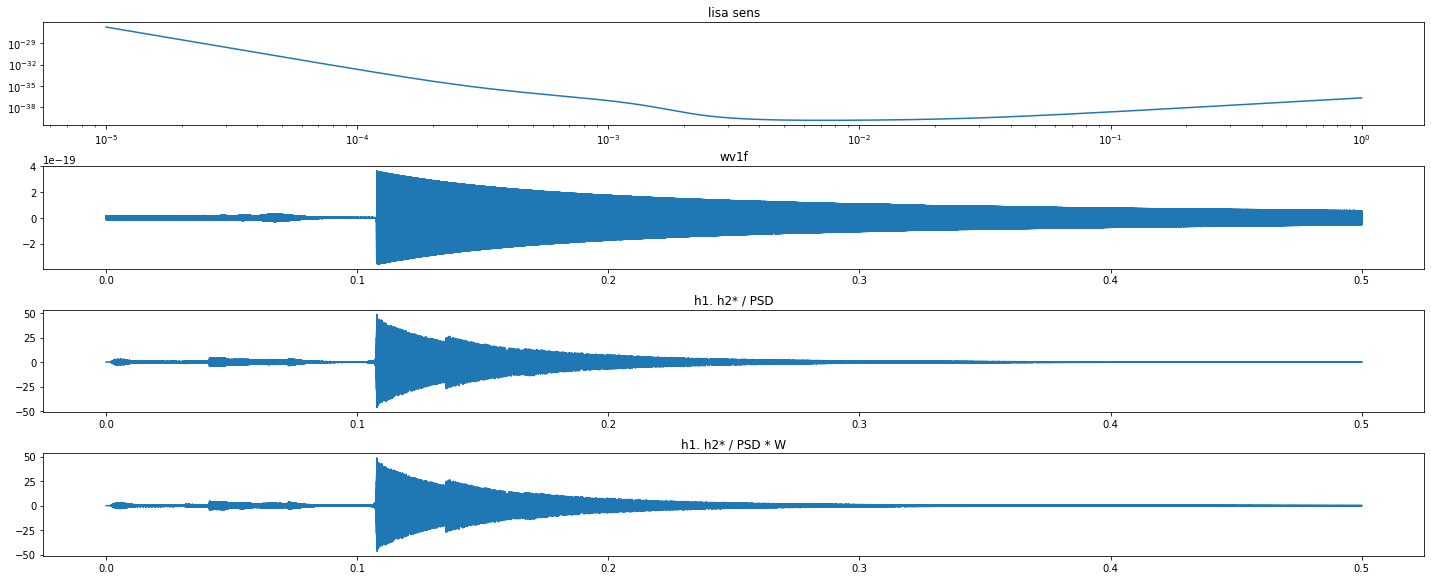

In [195]:
dom = np.arange(1e-5,1,1e-5)
ran = LisaSensitivity(dom)
fig,ax = plt.subplots(4,1,figsize=(20,8))
fig.tight_layout()
plt.subplots_adjust(hspace=0.4)
ax[0].loglog(dom,ran)
ax[0].set_title("lisa sens")
ax[1].plot(freqs,wv1f)
ax[1].set_title("wv1f")
ax[2].plot(freqs, wv1f*np.conjugate(wv2f)/lisasen)
ax[2].set_title("h1. h2* / PSD");
ran = [tophat(x,0.0001,1.) for x in freqs]
ax[3].plot(freqs, wv1f*np.conjugate(wv2f)/lisasen *ran)
ax[3].set_title("h1. h2* / PSD * W");

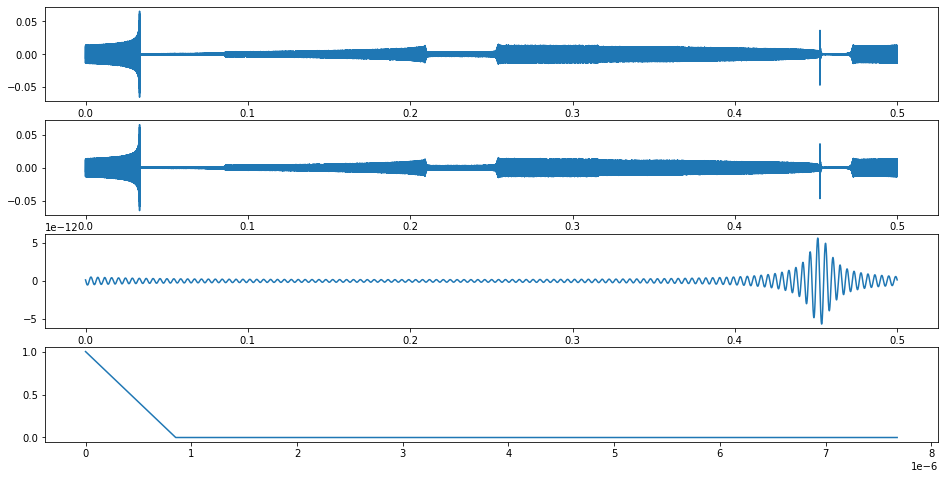

In [197]:
fig,ax = plt.subplots(4,1,figsize=(16,8))
ax[0].plot(freqs,np.fft.ifft(wv1f*np.conjugate(wv2f)/lisasen *ran))
ax[1].plot(freqs,np.fft.ifft(wv1f*np.conjugate(wv2f)/lisasen ))
ax[2].plot(freqs,np.fft.ifft(wv1f*np.conjugate(wv2f)/lisasen *ran)-np.fft.ifft(wv1f*np.conjugate(wv2f)/lisasen))
ax[3].plot(freqs[:10],np.fft.ifft(ran)[:10])